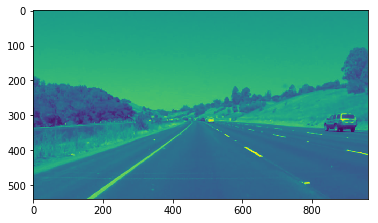

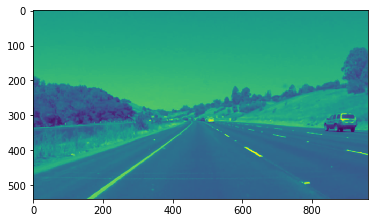

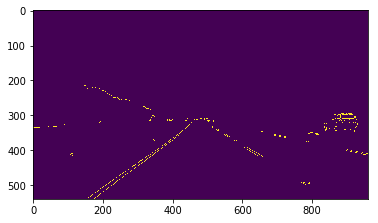

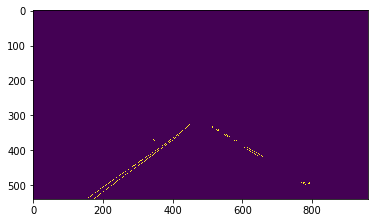

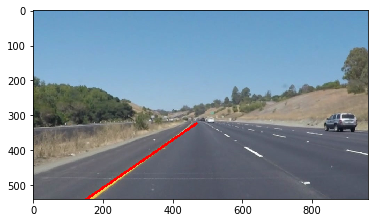

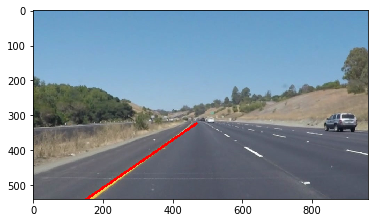

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4



















  0%|          | 0/222 [00:00<?, ?it/s]
















  4%|▎         | 8/222 [00:00<00:02, 76.24it/s]
















  8%|▊         | 17/222 [00:00<00:02, 81.39it/s]
















 12%|█▏        | 27/222 [00:00<00:02, 86.78it/s]
















 16%|█▌        | 36/222 [00:00<00:02, 87.27it/s]
















 21%|██        | 46/222 [00:00<00:01, 89.12it/s]
















 24%|██▍       | 54/222 [00:00<00:02, 82.96it/s]
















 28%|██▊       | 62/222 [00:00<00:01, 81.43it/s]
















 32%|███▏      | 71/222 [00:00<00:01, 81.83it/s]
















 36%|███▌      | 80/222 [00:00<00:01, 82.40it/s]
















 40%|███▉      | 88/222 [00:01<00:01, 82.18it/s]
















 43%|████▎     | 96/222 [00:01<00:01, 81.36it/s]
















 47%|████▋     | 104/222 [00:01<00:01, 80.98it/s]
















 50%|█████     | 112/222 [00:01<00:01, 80.42it/s]
















 54%|█████▍    | 120/222 [00:01<00:01, 80.13it/s]
















 58%|█████▊    

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 2.3 s, sys: 414 ms, total: 2.71 s
Wall time: 3.19 s


In [190]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML


%matplotlib inline

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def separate_line_by_slope( lines ):
    """
    Function to separate lines for 2 difference groups with left and right side
    :param lines: array of lines
    :return lines_l, lines_r - array of point sorted by left and right side
    """
    
    slope_left = []
    slope_right = []
    
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            if slope < 0:
                slope_left.append([x1,y1,x2,y2])
            else:
                slope_right.append([x1,y1,x2,y2])
               
    
    return slope_left,slope_right

def fit_line_roi(line, shape, y_top):
    """
    Convert line in "plotted" format and cut to ROI area
    :param line: line in cv2.fitLine() output format (orthogonal vector to line and point on line)
    :param shape: shape of picture
    :param y_top: top bound of ROI
    :return: line in common format [x0, y0, x1, y1]
    """
    if np.isnan(line[0]) or np.isnan(line[1]) or np.isnan(line[2]) or np.isnan(line[3]):
        raise Exception("No data")
    else:
    
        epsilon = 0.001

        # if slope of the line is too small, we just assume it is a vertical one
        # (avoiding division by zero)
        if abs(line[0]) < epsilon:
            x_bot = line[3]
            x_top = line[3]
        else:
            t_bot = float((shape[1] - line[2]) / line[0])
            x_bot = int(t_bot * line[1] + line[3])
            t_top = float((y_top - line[2]) / line[0])
            x_top = int(t_top * line[1] + line[3])

        return np.array([x_bot, shape[1], x_top, y_top])

def fit_line( lines, shape ):
    """
    Function to find the line which fits points in lines variable
    :param line: set of lines
    :param shape: shape of the picture
    :return: line in cv2.fitLine() output format (orthogonal vector to line and point on line)
    """

    color = 255
    thickness = 1

    img = np.zeros((shape[0], shape[1]), dtype=np.uint8)
    for line in lines:
        cv2.line(img, (line[0], line[1]), (line[2], line[3]), color, thickness)

    # find non zero points (line points) and get it as array with .shape = (n, 2) to feed into cv2.fitLine
    points = np.transpose(np.array(np.nonzero(img)))
    line = cv2.fitLine(points, cv2.DIST_L2, 0, 2, 0.01)
    return line


def draw_lines(img, sep_lines, color=[255, 0, 0], thickness=2, shape=[540,960]):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    for line in sep_lines:
        if len( line ) > 0:
            curv = fit_line( line, image.shape )
            if len(curv) > 3:
                cnt = 0
                try:
                    curv_in_raw = fit_line_roi( curv, shape, int(shape[0] * 0.6) )
                    cv2.line(img, (curv_in_raw[0], curv_in_raw[1]), (curv_in_raw[2], curv_in_raw[3]), color, thickness)
                    cnt = cnt + 1
                except Exception as error:
                    print("can't write line")
    return img

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    #line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    #draw_lines(line_img, lines)
    #return line_img
    return lines

def hough_lines_show( lines, shape, color=[255, 0, 0], thickness=2 ):
    """
    Function to visualize hough lines on the picture
    """
    line_img = np.zeros((shape[0], shape[1], 3), dtype=np.uint8)

    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(line_img, (x1, y1), (x2, y2), color, thickness)

    return line_img
    

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)



def process_image(img, debug=False):
    """
    Function to process image and put lane markers on it
    :param img: image for line lanes detection
    :param debug: write or not some additional infomation and save images on different steps
    """
    
    shape = img.shape

    
    # Step 1. Convert image to grayscale
    
    gray_img = grayscale( img )
    
    if debug:
        cv2.imwrite('report_images/gray.png',gray_img)
        plt.imshow(gray_img)
        plt.show()

    
    # Step 2. Gaus blur
    kernel_size = 3
    blur_gray = gaussian_blur(gray_img, kernel_size)
    
    if debug:
        cv2.imwrite('report_images/blur.png',blur_gray)
        plt.imshow(blur_gray)
        plt.show()
    
    # Step 3. Canny edges
    low_threshold = 150
    high_threshold = 300

    edges = canny(blur_gray, low_threshold, high_threshold)
    
    
    if debug:
        cv2.imwrite('report_images/edges.png',edges)
        plt.imshow(edges)
        plt.show()
    
    # Step 4. Cut region of interesting
    
    height_cut = 0.6
    width_cut  = 0.375
    cut_height = int(shape[0] * height_cut)
    cut_width_left = int(shape[1] * width_cut)
    cut_width_right = shape[1] - cut_width_left

    cut_point_left = (cut_width_left, cut_height)
    cut_point_right = (cut_width_right, cut_height)
    vertices = np.array([[(0, shape[0]), cut_point_left, cut_point_right, (shape[1], shape[0])]], dtype=np.int32)
    
    masked_edges = region_of_interest(edges, vertices)
    
    if debug:
        cv2.imwrite('report_images/masked_edges.png', masked_edges )
        plt.imshow(masked_edges)
        plt.show()
    
    
    # Step 5. Perform Hough transform
    rho = 2
    theta = 1
    threshold = 40
    min_line_len = 80
    max_line_gap = 120
    
    
    lines = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)

    
    if debug:
        line_img = hough_lines_show(lines, shape)
        cv2.imwrite('report_images/hough.png', cv2.cvtColor(line_img, cv2.COLOR_RGB2BGR))
        combo = weighted_img(img, line_img, 1, 0.9)
        cv2.imwrite('report_images/combo_hough.png', cv2.cvtColor(combo, cv2.COLOR_RGB2BGR))


    # Step 6. Separate lines by left and right side
    
    # Separate lines array into 2 segments
    sep_lines = separate_line_by_slope(lines)
    
    if debug:
        temp_img = np.zeros_like(img)
        draw_lines(temp_img, [sep_lines[0]])
        cv2.imwrite('report_images/left_side.png', cv2.cvtColor(temp_img, cv2.COLOR_RGB2BGR))
        temp_img = np.zeros_like(img)
        draw_lines(temp_img, [sep_lines[1]])
        cv2.imwrite('report_images/right_side.png', cv2.cvtColor(temp_img, cv2.COLOR_RGB2BGR))

    
    # Step 7. Draw lane lines
    img = draw_lines(img,sep_lines,thickness=5)

    
    if debug:
        cv2.imwrite('report_images/result.png', cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

        plt.imshow(img)
        plt.show()
    
    return img
    


def get_list_of_files(dir_path):
    """
    Get list of images in folder 'folder_name'
    :param dir_path:
    :return: list_of_paths:
    """
    file_list = os.listdir(dir_path)
    list_of_paths = [os.path.join(dir_path, file) for file in file_list]

    return list_of_paths

# Image Processing
image_dir_path = 'test_images/'
image_list = get_list_of_files(image_dir_path)
image = mpimg.imread(image_list[2])
res_image = process_image(image,True)
plt.imshow(res_image)
plt.show()

white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))